# Определение эмоциональной окраски твитов с помощью BERT

In [0]:
# Если Вы запускаете ноутбук на colab или kaggle,
# выполните следующие строчки, чтобы подгрузить библиотеку dlnlputils:

!git clone https://github.com/Samsung-IT-Academy/stepik-dl-nlp.git
import sys; sys.path.append('./stepik-dl-nlp')

fatal: destination path 'stepik-dl-nlp' already exists and is not an empty directory.


In [0]:
pip install -r stepik-dl-nlp/requirements.txt

In [0]:
!nvidia-smi

Fri Apr 24 18:51:31 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    31W / 250W |   2837MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
import gc # чистим память если что-то пошло не так
model_new = None
gc.collect()
torch.cuda.empty_cache()

## Установка библиотек

In [0]:
!pip install pytorch-transformers

In [0]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_transformers import BertTokenizer, BertConfig
from pytorch_transformers import AdamW, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device == 'cpu':
    print('cpu')
else:
    n_gpu = torch.cuda.device_count()
    print(torch.cuda.get_device_name(0))

Tesla P100-PCIE-16GB


## Загрузка данных


Мы выбрали необычный датасет с разметкой сентимента русскоязычных твитов (подробнее про него в [статье](http://www.swsys.ru/index.php?page=article&id=3962&lang=)). В корпусе, который мы использовали 114,911 положительных и 111,923 отрицательных записей. Загрузить его можно [тут](https://study.mokoron.com/).

In [0]:
import pandas as pd

# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
pos_texts = pd.read_csv('./stepik-dl-nlp/datasets/bert_sentiment_analysis/positive.csv', encoding='utf8', sep=';', header=None)
neg_texts = pd.read_csv('./stepik-dl-nlp/datasets/bert_sentiment_analysis/negative.csv', encoding='utf8', sep=';', header=None)

In [0]:
pos_texts.sample(5)

,0,1,2,3,4,5,6,7,8,9,10,11
88614,410823939158310912,1386783034,ifiremen,"@ArahmoCom @tam4man волейбол уже игровой, он п...",1,0,0,0,7798,167,70,4
91396,410853113008893952,1386789990,save_infants,Амтат хоолны жороороо танил А. Сийлэн хоолны н...,1,0,0,0,650,564,969,5
99807,411075144032198656,1386842926,ipyqidajs,повадки обезьян: много букв на английском. Н...,1,0,0,0,214,246,205,0
84789,410788839184019456,1386774666,Tumanova_Inna,"История, я тебя ненавижу.\nНо я тебя все равно...",1,0,0,0,325,17,41,0
87398,410813718474522624,1386780597,tralfamadority,@DarjaKurkina я только сейчас поняла)\nА еще д...,1,0,0,0,5428,53,53,0


In [0]:
sentences = np.concatenate([pos_texts[3].values, neg_texts[3].values])

sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = [[1] for _ in range(pos_texts.shape[0])] + [[0] for _ in range(neg_texts.shape[0])]


In [0]:
assert len(sentences) == len(labels) == pos_texts.shape[0] + neg_texts.shape[0]

In [0]:
print(sentences[1000])

[CLS] Дим, ты помогаешь мне, я тебе, все взаимно, все правильно) [SEP]


In [0]:
from sklearn.model_selection import train_test_split

train_sentences, test_sentences, train_gt, test_gt = train_test_split(sentences, labels, test_size=0.3)

In [0]:
print(len(train_gt), len(test_gt))

158783 68051


## Inputs

In [0]:
from pytorch_transformers import BertTokenizer, BertConfig


tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sent) for sent in train_sentences]
print (tokenized_texts[0])

100%|██████████| 231508/231508 [00:00<00:00, 877194.58B/s]


['[CLS]', '@', 'vlad', '##a', '_', 'du', '##sy', '##a', 'а', '##х', '##а', '##х', '##х', '##а', '##х', '##а', '##х', 'а', 'я', 'н', '##и', '##ч', '##е', '##г', '##о', 'н', '##е', 'у', '##ч', '##и', '##л', '##а', 'и', 'н', '##е', 'ч', '##и', '##т', '##а', '##л', '##а', ',', 'и', 'у', 'м', '##е', '##н', '##я', 'н', '##е', 'а', '##в', '##т', '##о', '##м', '##а', '##т', ')', ')', ')', 'с', '##е', '##г', '##о', '##д', '##н', '##я', 'м', '##о', '##и', 'д', '##е', '##н', '##ь', 'п', '##о', '##х', '##о', '##д', '##у', '[SEP]']


BERTу нужно предоставить специальный формат входных данных.


- **input ids**: последовательность чисел, отождествляющих каждый токен с его номером в словаре.
- **labels**: вектор из нулей и единиц. В нашем случае нули обозначают негативную эмоциональную окраску, единицы - положительную.
- **segment mask**: (необязательно) последовательность нулей и единиц, которая показывает, состоит ли входной текст из одного или двух предложений. Для случая одного предложения получится вектор из одних нулей. Для двух: <length_of_sent_1> нулей и <length_of_sent_2> единиц.
- **attention mask**: (необязательно) последовательность нулей и единиц, где единицы обозначают токены предложения, нули - паддинг.

In [0]:
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(
    input_ids,
    maxlen=100,
    dtype="long",
    truncating="post",
    padding="post"
)
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

In [0]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(
    input_ids, train_gt, 
    random_state=42,
    test_size=0.1
)

train_masks, validation_masks, _, _ = train_test_split(
    attention_masks,
    input_ids,
    random_state=42,
    test_size=0.1
)

In [0]:
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)

In [0]:
validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)

In [0]:
train_labels

tensor([[0],
        [0],
        [0],
        ...,
        [1],
        [0],
        [1]])

In [0]:
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(
    train_data,
    sampler=RandomSampler(train_data),
    batch_size=32
)

In [0]:
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_dataloader = DataLoader(
    validation_data,
    sampler=SequentialSampler(validation_data),
    batch_size=32
)

## Обучение модели

Загружаем [BertForSequenceClassification](https://github.com/huggingface/pytorch-pretrained-BERT/blob/master/pytorch_pretrained_bert/modeling.py#L1129):

In [0]:
from pytorch_transformers import AdamW, BertForSequenceClassification

Аналогичные модели есть и для других задач:

In [0]:
from pytorch_transformers import BertForQuestionAnswering, BertForTokenClassification

In [0]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.cuda()

In [0]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)



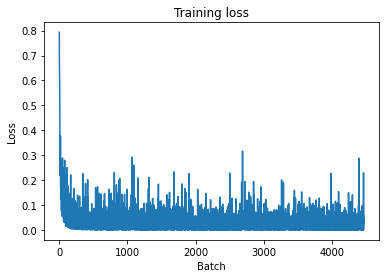

Loss на обучающей выборке: 0.03798
Процент правильных предсказаний на валидационной выборке: 98.27%


In [0]:
from IPython.display import clear_output

# Будем сохранять loss во время обучения
# и рисовать график в режиме реального времени
train_loss_set = []
train_loss = 0


# Обучение
# Переводим модель в training mode
model.train()


for step, batch in enumerate(train_dataloader):
    # добавляем батч для вычисления на GPU
    batch = tuple(t.to(device) for t in batch)
    # Распаковываем данные из dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # если не сделать .zero_grad(), градиенты будут накапливаться
    optimizer.zero_grad()
    
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

    train_loss_set.append(loss[0].item())  
    
    # Backward pass
    loss[0].backward()
    
    # Обновляем параметры и делаем шаг используя посчитанные градиенты
    optimizer.step()

    # Обновляем loss
    train_loss += loss[0].item()
    
    # Рисуем график
    clear_output(True)
    plt.plot(train_loss_set)
    plt.title("Training loss")
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.show()
    
print("Loss на обучающей выборке: {0:.5f}".format(train_loss / len(train_dataloader)))


# Валидация
# Переводим модель в evaluation mode
model.eval()

valid_preds, valid_labels = [], []

for batch in validation_dataloader:   
    # добавляем батч для вычисления на GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Распаковываем данные из dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # При использовании .no_grad() модель не будет считать и хранить градиенты.
    # Это ускорит процесс предсказания меток для валидационных данных.
    with torch.no_grad():
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # Перемещаем logits и метки классов на CPU для дальнейшей работы
    logits = logits[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    batch_preds = np.argmax(logits, axis=1)
    batch_labels = np.concatenate(label_ids)     
    valid_preds.extend(batch_preds)
    valid_labels.extend(batch_labels)

print("Процент правильных предсказаний на валидационной выборке: {0:.2f}%".format(
    accuracy_score(valid_labels, valid_preds) * 100
))

In [0]:
print("Процент правильных предсказаний на валидационной выборке: {0:.2f}%".format(
    accuracy_score(valid_labels, valid_preds) * 100
))

Процент правильных предсказаний на валидационной выборке: 98.27%


# Оценка качества на отложенной выборке

In [0]:
tokenized_texts = [tokenizer.tokenize(sent) for sent in test_sentences]
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

input_ids = pad_sequences(
    input_ids,
    maxlen=100,
    dtype="long",
    truncating="post",
    padding="post"
)

In [0]:
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(test_gt)

prediction_data = TensorDataset(
    prediction_inputs,
    prediction_masks,
    prediction_labels
)

prediction_dataloader = DataLoader(
    prediction_data, 
    sampler=SequentialSampler(prediction_data),
    batch_size=32
)

In [0]:
model.eval()
test_preds, test_labels = [], []

for batch in prediction_dataloader:
    # добавляем батч для вычисления на GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Распаковываем данные из dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # При использовании .no_grad() модель не будет считать и хранить градиенты.
    # Это ускорит процесс предсказания меток для тестовых данных.
    with torch.no_grad():
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # Перемещаем logits и метки классов на CPU для дальнейшей работы
    logits = logits[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Сохраняем предсказанные классы и ground truth
    batch_preds = np.argmax(logits, axis=1)
    batch_labels = np.concatenate(label_ids)  
    test_preds.extend(batch_preds)
    test_labels.extend(batch_labels)

In [0]:
acc_score = accuracy_score(test_labels, test_preds)
print('Процент правильных предсказаний на отложенной выборке составил: {0:.2f}%'.format(
    acc_score*100
))

Процент правильных предсказаний на отложенной выборке составил: 98.05%


In [0]:
print('Неправильных предсказаний: {0}/{1}'.format(
    sum([z[0] != z[1] for z in zip(test_labels,  test_preds)]),
    len(test_labels)
))

Неправильных предсказаний: 1327/68051


### Домашнее задание

Скачайте датасет с отзывами на фильмы. Например, используйте датасет [IMDB Dataset of 50K Movie Reviews](https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews). 

In [0]:
from google.colab import files

file = files.upload()

Saving kaggle.json to kaggle.json


In [0]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle

 19% 5.00M/25.7M [00:00<00:00, 26.2MB/s]
100% 25.7M/25.7M [00:00<00:00, 86.0MB/s]


In [0]:
!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

In [0]:
!unzip imdb-dataset-of-50k-movie-reviews.zip


Archive:  imdb-dataset-of-50k-movie-reviews.zip
  inflating: IMDB Dataset.csv        


In [0]:
ls

'IMDB Dataset.csv'                       sample_data/
 imdb-dataset-of-50k-movie-reviews.zip   stepik-dl-nlp/


In [0]:
import pandas as pd

dataset = pd.read_csv('IMDB Dataset.csv')

In [0]:
dataset.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [0]:
sents = np.concatenate([dataset["review"].values])
sents = ["[CLS] " + sent + " [SEP]" for sent in sents]
lab = [[1] if i == 'positive' else [0] for i in dataset["sentiment"]]

print(sents[10])
print(lab)

assert len(sents) == len(lab)

[CLS] Phil the Alien is one of those quirky films where the humour is based around the oddness of everything rather than actual punchlines.<br /><br />At first it was very odd and pretty funny but as the movie progressed I didn't find the jokes or oddness funny anymore.<br /><br />Its a low budget film (thats never a problem in itself), there were some pretty interesting characters, but eventually I just lost interest.<br /><br />I imagine this film would appeal to a stoner who is currently partaking.<br /><br />For something similar but better try "Brother from another planet" [SEP]
[[1], [1], [1], [0], [1], [1], [1], [0], [0], [1], [0], [0], [0], [0], [1], [0], [1], [0], [1], [0], [1], [0], [1], [0], [0], [1], [1], [0], [0], [1], [1], [1], [0], [1], [0], [0], [0], [0], [1], [0], [0], [1], [0], [0], [1], [1], [0], [0], [1], [0], [1], [1], [1], [1], [0], [0], [0], [0], [1], [1], [0], [0], [1], [0], [0], [1], [0], [0], [0], [0], [0], [0], [1], [1], [0], [1], [1], [0], [0], [1], [1], [0]

In [0]:
train_sents, test_sents, train_gt_new, test_gt_new = train_test_split(sents, lab, test_size=0.3)

In [0]:
from pytorch_transformers import BertTokenizer, BertConfig

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenized_texts_new = [tokenizer.tokenize(sent) for sent in train_sents]
print (tokenized_texts_new[0])

['[CLS]', 'i', 'have', 'seen', 'nearly', 'all', 'the', 'films', 'of', 'ku', '##ros', '##awa', 'and', 'dozens', 'of', 'other', 'japanese', 'films', 'as', 'well', '.', 'compared', 'to', 'these', 'other', 'films', ',', 'this', 'is', 'a', 'rather', 'average', 'to', 'poor', 'film', '.', 'the', 'plot', 'features', 'two', 'warring', 'brothers', '-', '-', 'neither', 'one', 'of', 'which', 'i', 'cared', 'much', 'for', '-', '-', 'and', 'it', 'is', 'very', 'confusing', 'keeping', 'up', 'with', 'who', 'is', 'allied', 'with', 'who', '.', 'the', 'music', 'and', 'cinematography', 'is', 'pretty', 'good', ',', 'but', 'the', 'special', 'effects', ',', 'at', 'times', ',', 'are', 'terrible', '-', '-', 'rubber', 'heads', 'flying', 'off', 'with', 'about', 'the', 'same', 'realism', 'as', 'the', 'average', 'high', 'school', 'play', '!', 'on', 'top', 'of', 'these', 'complaints', ',', 'the', 'ending', 'of', 'the', 'movie', 'completely', 'destroys', 'and', 'undermine', '##s', 'the', 'entire', 'picture', '.', 'it'

In [0]:
input_ids_new = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts_new]
input_ids_new = pad_sequences(
    input_ids_new,
    maxlen=200,
    dtype="long",
    truncating="post",
    padding="post"
)
attention_masks_new = [[float(i>0) for i in seq] for seq in input_ids_new]

In [0]:
train_inputs_new, validation_inputs_new, train_labels_new, validation_labels_new = train_test_split(
    input_ids_new, train_gt_new, 
    random_state=42,
    test_size=0.1
)

train_masks_new, validation_masks_new, _, _ = train_test_split(
    attention_masks_new,
    input_ids_new,
    random_state=42,
    test_size=0.1
)

In [0]:
train_inputs_new = torch.tensor(train_inputs_new)
train_labels_new = torch.tensor(train_labels_new)
train_masks_new = torch.tensor(train_masks_new)

validation_inputs_new = torch.tensor(validation_inputs_new)
validation_labels_new = torch.tensor(validation_labels_new)
validation_masks_new = torch.tensor(validation_masks_new)

In [0]:
train_data_new = TensorDataset(train_inputs_new, train_masks_new, train_labels_new)
train_dataloader_new = DataLoader(
    train_data_new,
    sampler=RandomSampler(train_data_new),
    batch_size=32
)

In [0]:
validation_data_new = TensorDataset(validation_inputs_new, validation_masks_new, validation_labels_new)
validation_dataloader_new = DataLoader(
    validation_data_new,
    sampler=SequentialSampler(validation_data_new),
    batch_size=32
)

In [0]:
model_new = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model_new.cuda()

In [0]:
param_optimizer = list(model_new.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)

In [0]:
from IPython.display import clear_output

# Будем сохранять loss во время обучения
# и рисовать график в режиме реального времени
train_loss_set = []
train_loss = 0


# Обучение
# Переводим модель в training mode
model_new.train()


for step, batch in enumerate(train_dataloader_new):
    # добавляем батч для вычисления на GPU
    batch = tuple(t.to(device) for t in batch)
    # Распаковываем данные из dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # если не сделать .zero_grad(), градиенты будут накапливаться
    optimizer.zero_grad()
    
    # Forward pass
    loss = model_new(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

    train_loss_set.append(loss[0].item())  
    
    # Backward pass
    loss[0].backward()
    
    # Обновляем параметры и делаем шаг используя посчитанные градиенты
    optimizer.step()

    # Обновляем loss
    train_loss += loss[0].item()
    
    # Рисуем график
    clear_output(True)
    plt.plot(train_loss_set)
    plt.title("Training loss")
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.show()
    
print("Loss на обучающей выборке: {0:.5f}".format(train_loss / len(train_dataloader)))


# Валидация
# Переводим модель в evaluation mode
model_new.eval()

valid_preds, valid_labels = [], []

for batch in validation_dataloader_new:   
    # добавляем батч для вычисления на GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Распаковываем данные из dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # При использовании .no_grad() модель не будет считать и хранить градиенты.
    # Это ускорит процесс предсказания меток для валидационных данных.
    with torch.no_grad():
        logits = model_new(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # Перемещаем logits и метки классов на CPU для дальнейшей работы
    logits = logits[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    batch_preds = np.argmax(logits, axis=1)
    batch_labels = np.concatenate(label_ids)     
    valid_preds.extend(batch_preds)
    valid_labels.extend(batch_labels)

print("Процент правильных предсказаний на валидационной выборке: {0:.2f}%".format(
    accuracy_score(valid_labels, valid_preds) * 100
))

Buffered data was truncated after reaching the output size limit.

In [0]:
tokenized_texts = [tokenizer.tokenize(sent) for sent in test_sents];
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts];

input_ids = pad_sequences(
    input_ids,
    maxlen=100,
    dtype="long",
    truncating="post",
    padding="post"
);

In [0]:
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(test_gt_new)

prediction_data = TensorDataset(
    prediction_inputs,
    prediction_masks,
    prediction_labels
)

prediction_dataloader = DataLoader(
    prediction_data, 
    sampler=SequentialSampler(prediction_data),
    batch_size=32
)

In [0]:
model_new.eval()
test_preds, test_labels = [], []

for batch in prediction_dataloader:
    # добавляем батч для вычисления на GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Распаковываем данные из dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # При использовании .no_grad() модель не будет считать и хранить градиенты.
    # Это ускорит процесс предсказания меток для тестовых данных.
    with torch.no_grad():
        logits = model_new(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # Перемещаем logits и метки классов на CPU для дальнейшей работы
    logits = logits[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Сохраняем предсказанные классы и ground truth
    batch_preds = np.argmax(logits, axis=1)
    batch_labels = np.concatenate(label_ids)  
    test_preds.extend(batch_preds)
    test_labels.extend(batch_labels)

In [0]:
acc_score = accuracy_score(test_labels, test_preds)
print('Процент правильных предсказаний на отложенной выборке составил: {0:.2f}%'.format(
    acc_score*100
))

In [0]:
print('Неправильных предсказаний: {0}/{1}'.format(
    sum([z[0] != z[1] for z in zip(test_labels,  test_preds)]),
    len(test_labels)
))

Используйте для дообучения BERT датасет IMDB. 

Ответьте на вопросы:
1. удалось ли достичь такого же accuracy (98\%) при использовании IMDB датасета?
2. удалось ли получить хорошее качество классификации всего за одну эпоху?
3. подумайте, в чем может быть причина различий в дообучении одной и той же модели на разных датасетах
    - Внимательно изучите датасет с русскими твитами. В чем его особенности? Нет ли явных паттернов или ключевых слов, которые однозначно определяют сентимент твита?
    - Попробуйте удалить пунктуацию из датасета с русскими твитами и перезапустите дообучение модели. Изменилось ли итоговое качество работы модели? Почему?